<a href="https://colab.research.google.com/github/unicamp-dl/IA025_2022S1/blob/main/Final_project/Beatriz_e_Pedro/Image_captioning_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rede neural de legenda de imagens

## Bibliotecas

In [1]:
!pip install efficientnet_pytorch
!pip install transformers
!pip install pytorch-lightning
!pip install sacrebleu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=d7d3dec2d44920ed062dac76f90f7013dd93be14d930107a48c60ce90c657674
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 5.5 MB/s 
     |████████████████████████████████| 596 kB 65.6 MB/s 
     |████████████████████████████████| 6.6 MB 8.2 MB/s 
     |████████████████████████████████| 101 kB 10.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

In [9]:
import h5py, json
import numpy as np
import random
from PIL import Image
from IPython.display import display
from matplotlib import pyplot as plt
import os

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from pytorch_lightning.loggers import TensorBoardLogger

from efficientnet_pytorch import EfficientNet
from transformers import T5Tokenizer, T5ForConditionalGeneration
import pytorch_lightning as pl
import sacrebleu

from tqdm import tqdm

from google.colab import drive

drive.mount('/content/drive')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

os.cpu_count(), torch.cuda.get_device_name() if device == "cuda" else None

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(2, None)

## Dataset MS COCO

**Versão reduzida com 23 mil dados**

In [18]:
!wget https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/TEST_CAPTIONS_coco_5_cap_per_img.json
!wget https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/TEST_IMAGES_coco_5_cap_per_img.hdf5
!wget https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/VAL_CAPTIONS_coco_5_cap_per_img.json
!wget https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/VAL_IMAGES_coco_5_cap_per_img.hdf5
!wget https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/TRAIN_CAPTIONS_coco_5_cap_per_img.json
!wget https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/TRAIN_IMAGES_coco_5_cap_per_img.hdf5

--2022-06-22 13:49:52--  https://storage.googleapis.com/unicamp-dl/ia376j_2020s2/aula6/TEST_CAPTIONS_coco_5_cap_per_img.json
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 173.194.210.128, 173.194.213.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2022-06-22 13:49:52 ERROR 404: Not Found.

--2022-06-22 13:49:53--  https://storage.googleapis.com/unicamp-dl/ia376j_2020s2/aula6/TEST_IMAGES_coco_5_cap_per_img.hdf5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.97.128, 74.125.196.128, 74.125.134.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.97.128|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2022-06-22 13:49:53 ERROR 404: Not Found.

--2022-06-22 13:49:53--  https://storage.googleapis.com/unicamp-dl/ia376j_2020s2/aula6/VAL_CAPTIONS_coco_5_cap_per_img.json
Resolving stor

In [23]:
imgs = h5py.File('TRAIN_IMAGES_coco_5_cap_per_img.hdf5', 'r')
imgs.keys()

<KeysViewHDF5 ['images']>

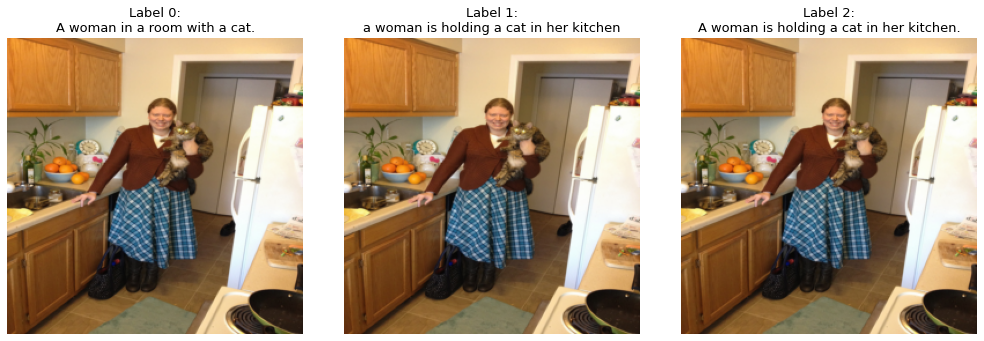

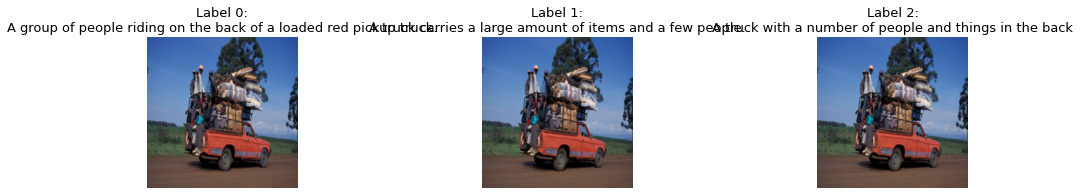

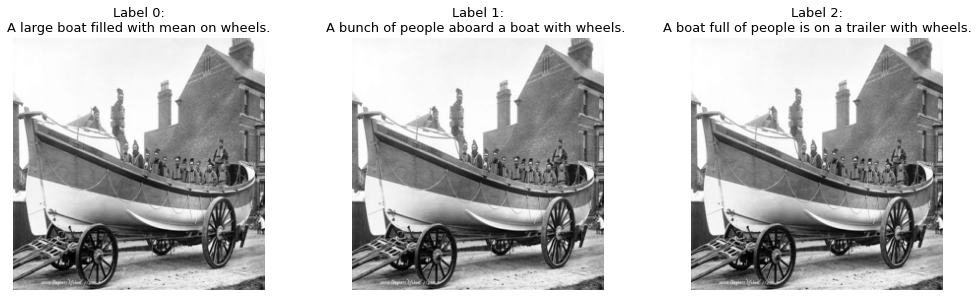

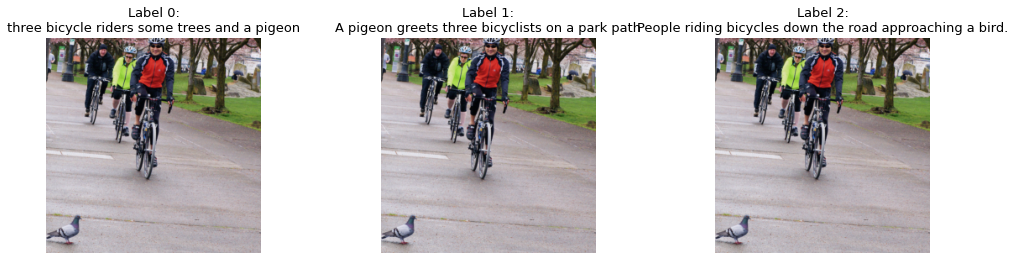

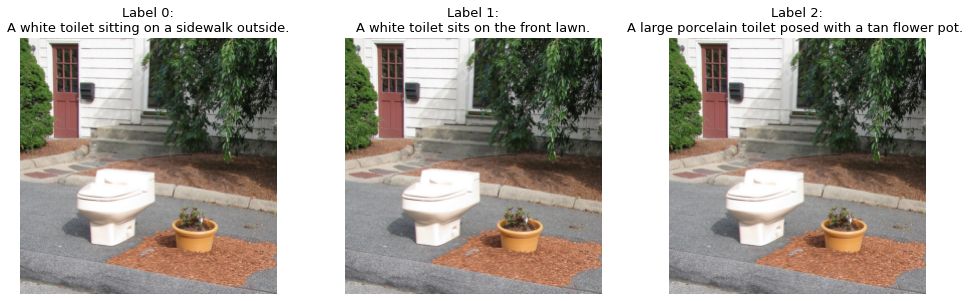

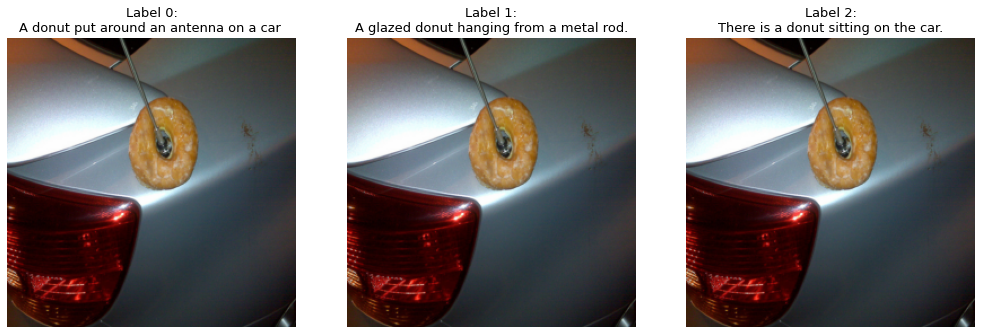

In [24]:
imgs_new = imgs['images']
# print('Types in images'
# '\n')
# print(f'type: {imgs_new.dtype} {type(imgs_new)} {type(imgs_new[0])}\nshape: {imgs_new.shape}'
# '\n')
# print('Types in captions'
# '\n')
# print(f'type: {type(captions)}, {type(captions[0])} len: {len(captions)}, {len(captions[0])}'
# '\n')

for j in range(6):
  img = Image.fromarray(imgs_new[j].transpose(1,2,0))
  # display(img)
  with open('TRAIN_CAPTIONS_coco_5_cap_per_img.json') as json_file:
      captions = json.load(json_file)
  fig, ax = plt.subplots(1, 3, figsize=(14,6))
  for i in range(3):
    ax[i].imshow(img)
    ax[i].set_title(f'Label {i}:'
    '\n'
    f'{captions[j][i]}', fontsize = 13)
    ax[i].axis('off')

  fig.patch.set_alpha(0.5)
  plt.tight_layout()
  plt.show()